In [1]:
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose


data_transform = Compose([
    ToTensor()
])


full_train_dataset = MNIST(root='mnist_data', train=True, download=True, transform=data_transform)


train_sample_size = 1500
random_indices = torch.randperm(len(full_train_dataset))[:train_sample_size]
train_dataset = Subset(full_train_dataset, random_indices)


test_dataset = MNIST(root='mnist_data', train=False, download=True, transform=data_transform)


train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=1)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=1)


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 477kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.71MB/s]


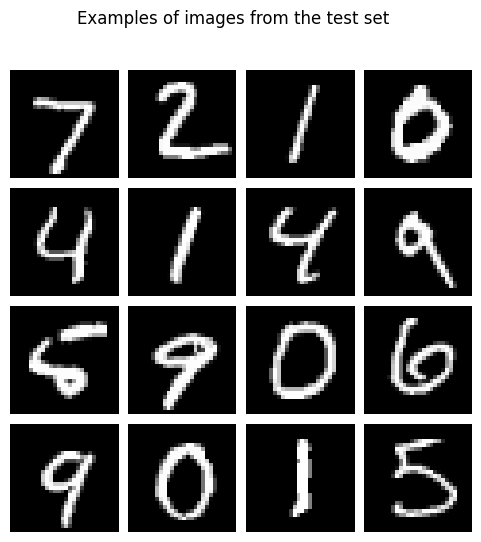

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


batch_idx, (images_batch, labels_batch) = next(iter(enumerate(test_loader)))


sample_images = [images_batch[i].squeeze().numpy() for i in range(16)]


fig = plt.figure(figsize=(6, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.1)

for ax, img in zip(grid, sample_images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle("Examples of images from the test set")
plt.show()


In [4]:
import torch.nn as nn
import torch

# Багатошаровий перцептрон
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=32, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, num_classes, bias=False)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return x


In [9]:
import torch.optim as optim
from torch.nn.functional import one_hot
from torcheval.metrics import MulticlassConfusionMatrix

device = 'cuda'

model = SimpleMLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=1.0)
loss_fn = nn.MSELoss()
conf_matrix = MulticlassConfusionMatrix(num_classes=10)

def train_epoch(model, loader, optimizer):
    model.train()
    epoch_losses, epoch_accs = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        preds = model(x)
        loss = loss_fn(preds, one_hot(y, num_classes=10).float())
        loss.backward()
        optimizer.step()

        acc = (preds.argmax(dim=1) == y).float().mean()
        epoch_losses.append(loss.cpu())
        epoch_accs.append(acc.cpu())

    return torch.stack(epoch_losses).mean(), torch.stack(epoch_accs).mean()

def eval_model(model, loader, update_conf=False):
    model.eval()
    all_losses, all_accs = [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            preds = model(x)
            loss = loss_fn(preds, one_hot(y, num_classes=10).float())

            if update_conf:
                conf_matrix.update(preds.argmax(dim=1), y)

            acc = (preds.argmax(dim=1) == y).float().mean()
            all_losses.append(loss.cpu())
            all_accs.append(acc.cpu())

    return torch.stack(all_losses).mean(), torch.stack(all_accs).mean()

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(150):
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer)
    te_loss, te_acc = eval_model(model, test_loader, update_conf=(epoch == 149))

    print(f"Epoch {epoch:03d}: Train Loss={tr_loss:.3f}, Acc={tr_acc:.2f} | Test Loss={te_loss:.3f}, Acc={te_acc:.2f}")

    train_losses.append(tr_loss.item())
    test_losses.append(te_loss.item())
    train_accs.append(tr_acc.item())
    test_accs.append(te_acc.item())

conf_matrix_result = conf_matrix.normalized('true')



Epoch 000: Train Loss=0.114, Acc=0.12 | Test Loss=0.091, Acc=0.20
Epoch 001: Train Loss=0.090, Acc=0.19 | Test Loss=0.090, Acc=0.20
Epoch 002: Train Loss=0.090, Acc=0.16 | Test Loss=0.089, Acc=0.19
Epoch 003: Train Loss=0.089, Acc=0.18 | Test Loss=0.089, Acc=0.19
Epoch 004: Train Loss=0.089, Acc=0.19 | Test Loss=0.089, Acc=0.20
Epoch 005: Train Loss=0.089, Acc=0.18 | Test Loss=0.089, Acc=0.24
Epoch 006: Train Loss=0.089, Acc=0.22 | Test Loss=0.089, Acc=0.27
Epoch 007: Train Loss=0.088, Acc=0.26 | Test Loss=0.088, Acc=0.30
Epoch 008: Train Loss=0.088, Acc=0.30 | Test Loss=0.088, Acc=0.31
Epoch 009: Train Loss=0.088, Acc=0.32 | Test Loss=0.088, Acc=0.34
Epoch 010: Train Loss=0.087, Acc=0.35 | Test Loss=0.087, Acc=0.35
Epoch 011: Train Loss=0.087, Acc=0.32 | Test Loss=0.087, Acc=0.37
Epoch 012: Train Loss=0.087, Acc=0.36 | Test Loss=0.086, Acc=0.38
Epoch 013: Train Loss=0.086, Acc=0.37 | Test Loss=0.085, Acc=0.41
Epoch 014: Train Loss=0.085, Acc=0.41 | Test Loss=0.085, Acc=0.39
Epoch 015:

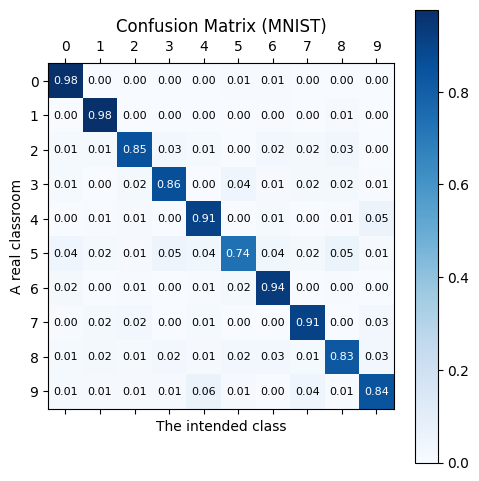

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def draw_conf_matrix(matrix, title="Confusion Matrix (MNIST)"):
    fig, ax = plt.subplots(figsize=(5, 5))
    cax = ax.matshow(matrix, cmap='Blues')
    fig.colorbar(cax)

    ticks = np.arange(10)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_yticklabels(ticks)

    for i in range(10):
        for j in range(10):
            ax.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center',
                    color='white' if matrix[i, j] > 0.5 else 'black', fontsize=8)

    ax.set_xlabel("The intended class")
    ax.set_ylabel("A real classroom")
    plt.title(title)
    plt.tight_layout()
    plt.show()

draw_conf_matrix(conf_matrix_result)


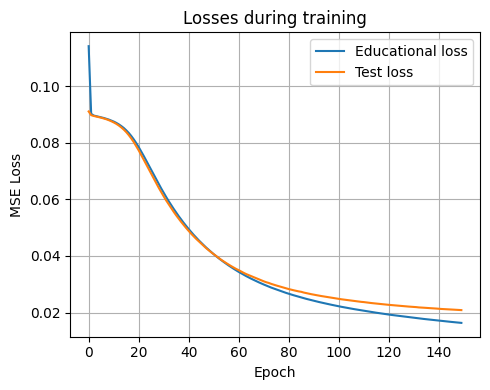

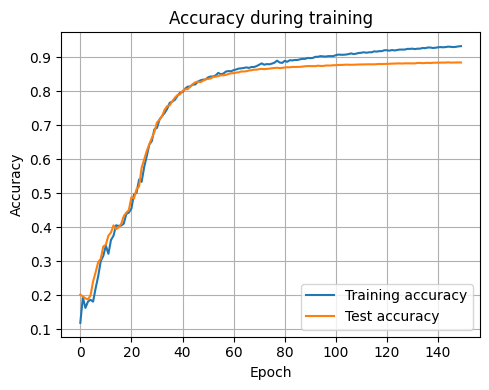

In [12]:
plt.figure(figsize=(5, 4))
plt.plot(train_losses, label='Educational loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Losses during training')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy during training')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


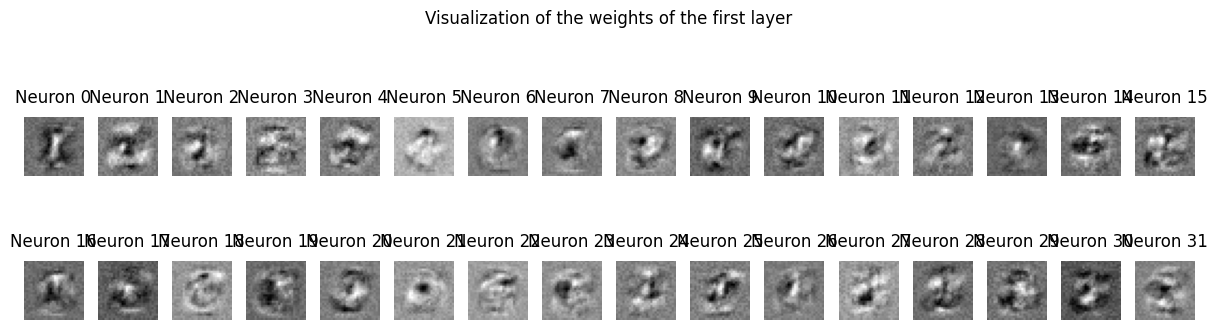

In [16]:
weights_layer1 = model.fc1.weight.detach().cpu()

fig, axs = plt.subplots(2, weights_layer1.size(0) // 2, figsize=(12, 4))
axs = axs.flatten()

for idx, ax in enumerate(axs):
    ax.imshow(weights_layer1[idx].view(28, 28), cmap='gray')
    ax.set_title(f"Neuron {idx}", pad=10)  # додаємо відступ між заголовком і зображенням
    ax.axis('off')

plt.suptitle("Visualization of the weights of the first layer")
plt.tight_layout()
plt.show()





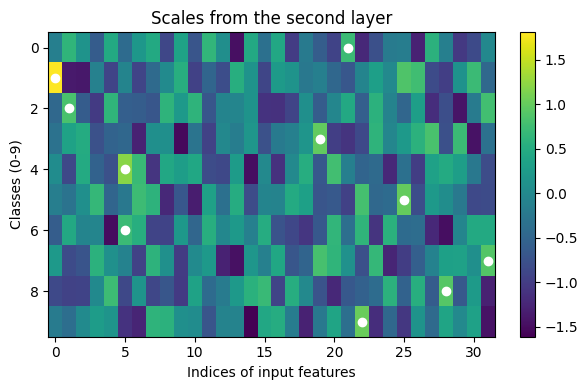

Dimension of the scales: (10, 32)


In [18]:
layer2_weights = model.fc2.weight.detach().cpu().numpy()

plt.figure(figsize=(6, 4))
heatmap = plt.imshow(layer2_weights, cmap='viridis', aspect='auto')
plt.colorbar(heatmap, fraction=0.05)

plt.xlabel("Indices of input features")
plt.ylabel("Classes (0-9)")
plt.title("Scales from the second layer")

for y in range(layer2_weights.shape[0]):
    max_x = np.argmax(layer2_weights[y])
    plt.plot(max_x, y, 'wo')

plt.tight_layout()
plt.show()
print("Dimension of the scales:", layer2_weights.shape)
